
# Illumination Optimization using Least Squares

## Problem Statement
A set of *n* lamps illuminates an area divided into *m* regions (pixels). The goal is to determine the optimal power levels for each lamp to achieve a desired illumination pattern across the area.

### Definitions:
- **lᵢ**: The lighting level at pixel *i*, forming an *m*-vector **l**.
- **pᵢ**: The power at which lamp *i* operates, forming an *n*-vector **p**.
- **A**: An *m × n* matrix where each column represents the illumination pattern of a single lamp when its power is set to 1 and all other lamps are off.

The illumination levels satisfy the linear relationship:
  
  $$l = A p$$
  
where **A** has linearly independent columns (i.e., *m > n*), making it a tall matrix. This ensures that each pixel's illumination depends uniquely on the combination of lamp powers.

## Objective
We aim to find lamp power levels **p** such that the resulting illumination pattern closely approximates a desired illumination **lₑ**. One typical objective is uniform illumination, where **lₑ** is a vector of all ones.

This is formulated as a **least squares problem**:

$$ \hat{p} = \arg\min_p \| A p - lₑ \|_2^2 $$

By solving this, we obtain the power levels **p** that minimize the deviation from the desired lighting pattern.

## Example Setup
To demonstrate this approach, we consider an area with the following parameters:
- **Number of lamps**: *n = 10*
- **Grid size**: *25 × 25* (total *m = 625* pixels)
- **Pixel size**: Each pixel represents *1m²*

### Lamp Positions and Heights
The lamps are positioned at various locations within the area, with varying heights above the floor. This affects the intensity distribution of each lamp.

#### First Set of Lamps:
1. **(4.1, 20.4, 4m)** - Located near the top-left corner.
2. **(14.1, 21.3, 3.5m)** - Slightly to the right of the first lamp.
3. **(22.6, 17.1, 6m)** - Positioned further right with a higher altitude.
4. **(5.5, 12.3, 4m)** - Closer to the center, at mid height.
5. **(12.2, 9.7, 4m)** - Another centrally positioned lamp with medium height.

#### Second Set of Lamps:
6. **(15.3, 13.8, 6m)** - Located near the center with higher illumination reach.
7. **(21.3, 10.5, 5.5m)** - Positioned further right at an intermediate height.
8. **(3.9, 3.3, 5m)** - Near the bottom-left corner.
9. **(13.1, 4.3, 5m)** - Slightly above the previous lamp with similar characteristics.
10. **(20.3, 4.2, 4.5m)** - A lamp near the bottom-right corner with lower height.





## Implementation

##Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pandas as pd

##Data Preprocessing


### 1. Initialization of Power of Ones



In [2]:
lamps = [(4.1, 20.4, 4), (14.1, 21.3, 3.5), (22.6, 17.1, 6),
        (5.5, 12.3, 4), (12.2, 9.7, 4), (15.3, 13.8, 6),
        (21.3, 10.5, 5.5), (3.9, 3.3, 5), (13.1, 4.3, 5),
        (20.3, 4.2, 4.5)]



# Define pixel grid (25x25)
x = np.linspace(1, 25, 25)  # Create 25 points between 0 and 25 for the x-axis
y = np.linspace(1, 25, 25)  # Create 25 points between 0 and 25 for the y-axis
X, Y = np.meshgrid(x, y)    # Create a 25x25 grid of (x, y) coordinates

# Reshape X and Y into a single array of (x, y) pairs
pixels = np.column_stack((X.reshape(-1), Y.reshape(-1)))

# Print the shape of the pixels array
print("Shape of pixels array:", pixels.shape)

# Desired illumination pattern
ldes = np.ones(625)

Shape of pixels array: (625, 2)


Matrix A contains information on illumination patters. The j-th column of A gives the illumination pattern for lamp j, if no other lamp is active in the room. The i-th row of A gives the sensitivity of pixel i to the n lamp powers. Matrix A has, consequently, a shape of 625x10:

###Compute Distance Matrix

In [3]:
def compute_distance_matrix(pixels, lamps):
    """
    Compute the 3D distance between each pixel and each lamp.
    :param pixels: (m x 2) array of pixel coordinates (x, y)
    :param lamps: List of lamp positions (x, y, height)
    :return: (m x n) distance matrix
    """
    m = pixels.shape[0]
    n = len(lamps)
    distance_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dx = pixels[i, 0] - lamps[j][0]
            dy = pixels[i, 1] - lamps[j][1]
            dz = 0 - lamps[j][2]  #  pixels are on the ground (z=0)
            distance_matrix[i, j] = np.sqrt(dx**2 + dy**2 + dz**2)
    return distance_matrix



###Compute Illumination Matrix

In [4]:
def compute_illumination_matrix(distance_matrix):
    """
    Compute the illumination matrix A using the inverse square law.
    :param distance_matrix: (m x n) distance matrix
    :return: (m x n) illumination matrix A
    """
    A = 1 / (distance_matrix**2)  # Inverse square law
    A = A / np.mean(A @ np.ones(A.shape[1]))  # Scale so that average illumination is 1
    return A



###Compute Illumination Pattern

In [5]:
def compute_illumination(A, p):
    """
    Compute the illumination pattern l = A @ p.
    :param A: (m x n) illumination matrix
    :param p: (n x 1) lamp power vector
    :return: (m x 1) illumination vector
    """
    return A @ p

###Compute RMS Error

In [6]:
def root_mean_squared_error(l, ldes):
    """
    Compute the Root Mean Squared (RMS) error between l and ldes.
    :param l: (m x 1) illumination vector
    :param ldes: (m x 1) desired illumination vector
    :return: RMS error
    """
    return np.sqrt(np.mean((l - ldes)**2))

###Plot Illumination Patterns

In [7]:
def plot_lamp_illumination(l_unsol, lamps, p_ones, title):
    """
    Plot the illumination pattern, pixel illumination distribution, and lamp power distribution.
    :param l_unsol: (m x 1) illumination vector
    :param lamps: List of lamp positions (x, y, height)
    :param p_ones: (n x 1) lamp power vector
    :param title: Title for the plot
    """
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Heatmap of illumination values
    sns.heatmap(
        l_unsol.reshape(25, 25),
        ax=axes[0],
        linewidth=0,
        xticklabels=[],
        yticklabels=[],
        cmap=sns.color_palette("Spectral_r", as_cmap=True)
    )

    # Plotting lamp coordinates on heatmap
    lamps_array = np.array(lamps)
    axes[0].scatter(
        lamps_array[:, 0],
        lamps_array[:, 1],
        marker='^',
        color='black'
    )
    axes[0].set_title(f'{title} - Room illumination', fontsize=10)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')

    # Lamp annotation on heatmap
    for i in range(len(lamps)):
        axes[0].text(
            lamps[i][0]-2.75,
            lamps[i][1]+0.75,
            '({}, {}, {})'.format(
                round(lamps[i][0],3),
                round(lamps[i][1],3),
                round(lamps[i][2],3)
            ),
            fontdict={'size': 6}
        )

    # Pixel illumination distribution histogram (flatten l_unsol)
    sns.histplot(ax=axes[1], x=l_unsol.flatten())
    axes[1].set_title(f'{title} - Pixel illumination distribution', fontsize=10)
    axes[1].set(xlabel='Pixel Illumination', ylabel='Frequency')

    # Lamp power distribution histogram (flatten p_ones)
    sns.histplot(ax=axes[2], x=p_ones.flatten())
    axes[2].set_title(f'{title} - Lamp power distribution', fontsize=10)
    axes[2].set(xlabel='Lamp Power', ylabel='Frequency')

    # Show the plots
    plt.show()

In [8]:
# Compute distance matrix and illumination matrix
distance_matrix = compute_distance_matrix(pixels, lamps)
A = compute_illumination_matrix(distance_matrix)

# Desired illumination pattern
ldes = np.ones(625)

#### 1. Using colormap, create two graphs to show the illumination of the two patterns: The first with all lamps set to 1 and the other that minimize the sum square deviation with a desired uniform illumination. Which are the Root Mean Squared (RMS) errors in both cases?


## All lamp powers set to 1
___

The equation that describes our problem is:

$$
A \cdot p = l
$$

where we set the vector \( p \) equal to ones:

$$
p = \mathbf{1}
$$


Case 1: All lamps at power 1
Power for lamp 1: 1.0
Power for lamp 2: 1.0
Power for lamp 3: 1.0
Power for lamp 4: 1.0
Power for lamp 5: 1.0
Power for lamp 6: 1.0
Power for lamp 7: 1.0
Power for lamp 8: 1.0
Power for lamp 9: 1.0
Power for lamp 10: 1.0
Total Power: 10.000
RMSE: 0.246


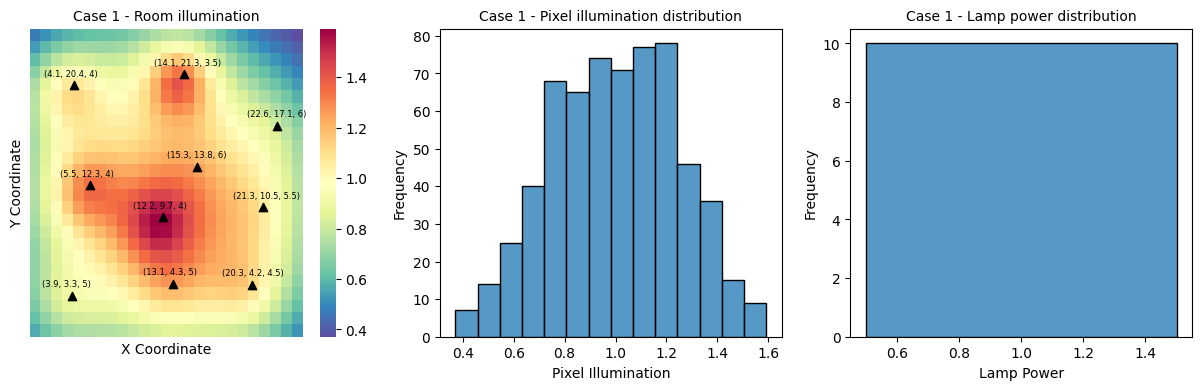

In [9]:


# Case 1: All lamps at power 1
p1 = np.ones(10)
l1 = compute_illumination(A, p1)
rmse1 = root_mean_squared_error(l1, ldes)
print("Case 1: All lamps at power 1")
for i in range(len(lamps)):
    print(f"Power for lamp {i+1}: {p1[i]}")
print(f"Total Power: {np.sum(p1):.3f}")
print(f"RMSE: {round(rmse1, 3)}")
plot_lamp_illumination(l1, lamps, p1, "Case 1")

## Lamp Powers using Least Squares
___

The analytical solution for the least squares (LS) problem is:
$$ p = (A^T A)^{-1} A^T l $$
where the vector  𝑙  is assigned the value of ones:

###Solve Least Squares Problem

In [10]:
def solve_least_squares(A, ldes):
    """
    Solve the least squares problem explicitly using matrix operations.
    :param A: (m x n) illumination matrix
    :param ldes: (m x 1) desired illumination vector
    :return: Optimal lamp powers p
    """
    return np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), ldes)


Case 2: Least squares solution
Power for lamp 1: 1.461
Power for lamp 2: 0.831
Power for lamp 3: 3.076
Power for lamp 4: 0.733
Power for lamp 5: 0.16
Power for lamp 6: 0.037
Power for lamp 7: 0.271
Power for lamp 8: 1.973
Power for lamp 9: 0.857
Power for lamp 10: 1.457
Total Power: 10.857
RMSE: 0.146


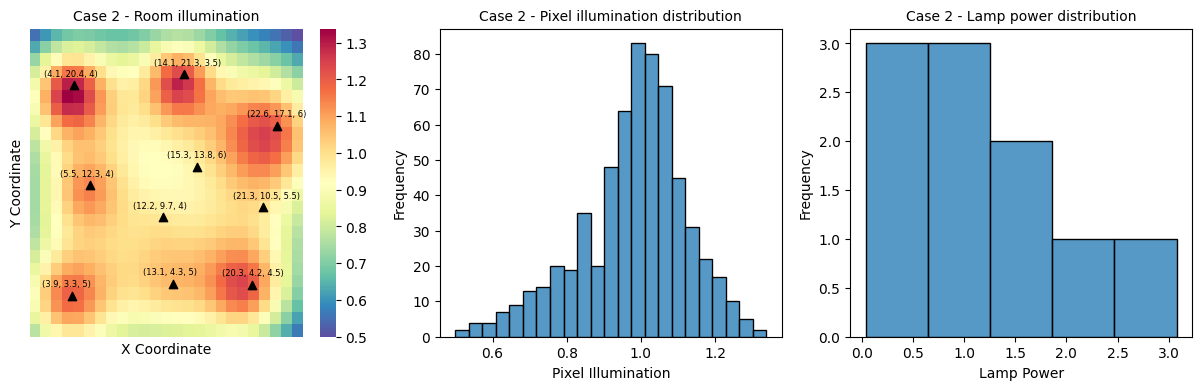

In [11]:
# Case 2: Least squares solution
p_ls = solve_least_squares(A, ldes)
l_ls = compute_illumination(A, p_ls)
rmse_ls = root_mean_squared_error(l_ls, ldes)
print("\nCase 2: Least squares solution")
for i in range(len(lamps)):
    print(f"Power for lamp {i+1}: {round(p_ls[i],3)}")
print(f"Total Power: {np.sum(p_ls):.3f}")
print(f"RMSE: {round(rmse_ls, 3)}")
plot_lamp_illumination(l_ls, lamps, p_ls, "Case 2")

## Lamp Powers using Constrained Least Squares
___

The analytical solution for the constrained least squares (LS) problem is:

$$ \hat{p} = \arg\min_p \| A p - lₑ \|_2^2 $$
with constrain $$ \sum_{i=1}^{10} p_i \quad \text{where} \quad p_i \geq 0 \quad \text{for all} \ i. $$


###Solve Constrained Optimization Problem
___

In [12]:
def solve_constrained_optimization(A, ldes, total_energy=10):
    """
    Solve the constrained optimization problem:
    min_p ||A @ p - ldes||^2, subject to sum(p) = total_energy and p >= 0.
    :param A: (m x n) illumination matrix
    :param ldes: (m x 1) desired illumination vector
    :param total_energy: Total energy constraint
    :return: Optimal lamp powers p
    """
    def objective_function(p):
        return np.sum((ldes - np.dot(A, p)) ** 2)

    def total_energy_constraint(p):
        return np.sum(p) - total_energy

    # Initial guess (equal distribution)
    p0 = np.ones(A.shape[1]) * (total_energy / A.shape[1])

    # Constraints and bounds
    constraints = [{'type': 'eq', 'fun': total_energy_constraint}]
    bounds = [(0, None) for _ in range(A.shape[1])]

    # Solve the optimization problem
    result = minimize(objective_function, p0, constraints=constraints, bounds=bounds)
    return result.x


Case 3: Constrained optimization (total energy = 10)
Power for lamp 1: 1.334
Power for lamp 2: 0.906
Power for lamp 3: 2.509
Power for lamp 4: 0.769
Power for lamp 5: 0.337
Power for lamp 6: 0.000
Power for lamp 7: 0.387
Power for lamp 8: 1.661
Power for lamp 9: 0.724
Power for lamp 10: 1.372
Total Power: 10.000
RMSE: 0.16


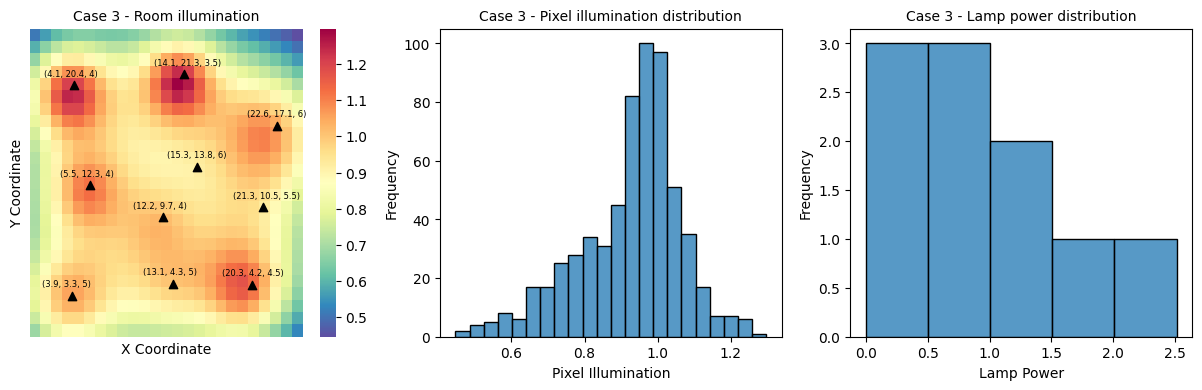

In [13]:
# Case 3: Constrained optimization (total energy = 10)
p_optimized = solve_constrained_optimization(A, ldes, total_energy=10)
l_optimized = compute_illumination(A, p_optimized)
rmse_optimized = root_mean_squared_error(l_optimized, ldes)
print("\nCase 3: Constrained optimization (total energy = 10)")
for i in range(len(p_optimized)):
    print(f"Power for lamp {i+1}: {p_optimized[i]:.3f}")
print(f"Total Power: {np.sum(p_optimized):.3f}")
print(f"RMSE: {round(rmse_optimized, 3)}")
plot_lamp_illumination(l_optimized, lamps, p_optimized, "Case 3")

## Lamp position optimization
___

In [14]:
def optimize_lamp_positions(pixels, num_trials=1000, total_energy=10):
    """
    Optimize lamp positions to minimize the RMS error.
    :param pixels: (m x 2) array of pixel coordinates (x, y)
    :param num_trials: Number of trials to run
    :param total_energy: Total energy constraint
    :return: Best lamp positions, best lamp powers, best RMS error
    """
    best_rms = float('inf')
    best_positions = None
    best_p = None

    for _ in range(num_trials):
        # Randomly generate lamp positions
        x_coords = np.random.uniform(0, 25, 10)  # 10 x-coordinates
        y_coords = np.random.uniform(0, 25, 10)  # 10 y-coordinates
        heights = np.random.uniform(4, 6, 10)    # 10 height values
        positions = np.column_stack((x_coords, y_coords, heights))

        # Compute distance matrix and illumination matrix
        distance_matrix = compute_distance_matrix(pixels, positions)
        A = compute_illumination_matrix(distance_matrix)

        # Solve the constrained optimization problem
        p = solve_constrained_optimization(A, ldes, total_energy=total_energy)

        # Compute illumination and RMS error
        l = compute_illumination(A, p)
        rms = root_mean_squared_error(l, ldes)

        # Update best solution
        if rms < best_rms:
            best_rms = rms
            best_positions = positions
            best_p = p

    return best_positions, best_p, best_rms


Case 4: Optimized lamp positions
Lamp 1 Position: [22.90785697 23.25562913  4.87446358] | Power: 1.340
Lamp 2 Position: [6.64572783 0.5368263  5.34183541] | Power: 0.875
Lamp 3 Position: [22.81170488  2.24101479  4.69362867] | Power: 1.476
Lamp 4 Position: [ 0.94444489 21.97387675  5.84339338] | Power: 0.365
Lamp 5 Position: [19.93926772 14.44474042  5.48187296] | Power: 1.483
Lamp 6 Position: [11.21622043  4.77357704  5.78806668] | Power: 0.932
Lamp 7 Position: [11.31218647 22.58833734  4.1107283 ] | Power: 0.710
Lamp 8 Position: [3.55893701 7.64724729 5.781993  ] | Power: 1.447
Lamp 9 Position: [ 2.92039997 21.650186    4.49822138] | Power: 0.992
Lamp 10 Position: [ 8.53285086 14.35751206  4.41845645] | Power: 0.378
Total Power: 10.000
RMSE: 0.097


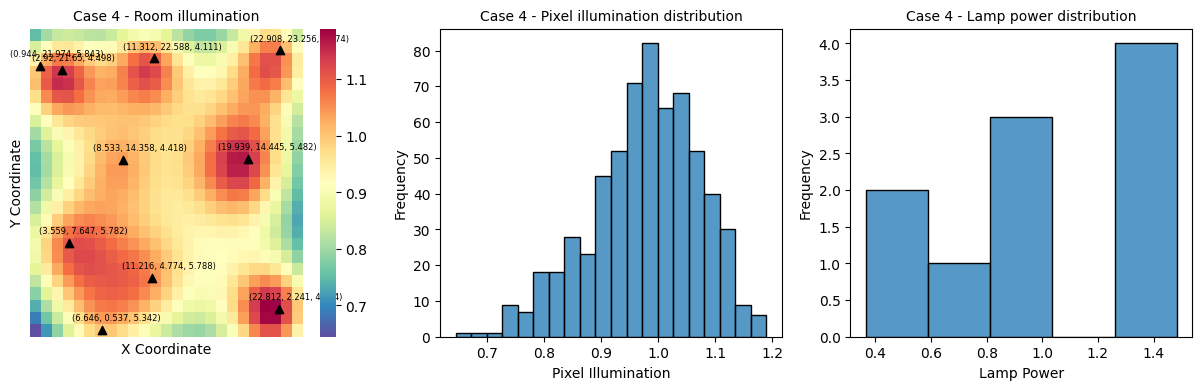

In [15]:
# Case 4: Optimize lamp positions
best_positions, best_p, best_rms = optimize_lamp_positions(pixels, num_trials=10000, total_energy=10)
print("\nCase 4: Optimized lamp positions")
for i in range(len(best_positions)):
    print(f"Lamp {i+1} Position: {best_positions[i]} | Power: {best_p[i]:.3f}")
print(f"Total Power: {np.sum(best_p):.3f}")
print(f"RMSE: {round(best_rms, 3)}")
plot_lamp_illumination(compute_illumination(compute_illumination_matrix(compute_distance_matrix(pixels, best_positions)), best_p), best_positions, best_p, "Case 4")


In [16]:

# Create a DataFrame to summarize the results
results = {
    "Method": ["All lamps at power 1", "Least squares solution", "Constrained optimization (total energy = 10)", "Optimized lamp positions"],
    **{f"Lamp {i+1}": [] for i in range(10)},  # Create columns for each lamp
    "Total Power": [],
    "RMSE": []
}

# List of power vectors, total energies, and RMSEs
power_vectors = [p1, p_ls, p_optimized, best_p]
total_energies = [np.sum(p1), np.sum(p_ls), np.sum(p_optimized), np.sum(best_p)]
rmses = [rmse1, rmse_ls, rmse_optimized, best_rms]

# Populate the results dictionary
for i, (p, energy, rmse) in enumerate(zip(power_vectors, total_energies, rmses)):
    for j in range(10):
        results[f"Lamp {j+1}"].append(p[j])
    results["Total Power"].append(energy)
    results["RMSE"].append(rmse)

# Convert to DataFrame
df = pd.DataFrame(results)
print("\nFinal Summary DataFrame:")
df


Final Summary DataFrame:


,Method,Lamp 1,Lamp 2,Lamp 3,Lamp 4,Lamp 5,Lamp 6,Lamp 7,Lamp 8,Lamp 9,Lamp 10,Total Power,RMSE
0,All lamps at power 1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,10.000000,0.245898
1,Least squares solution,1.460652,0.830642,3.076255,0.733060,0.160393,3.744517e-02,0.271192,1.972799,0.857122,1.457355,10.856915,0.145786
2,Constrained optimization (total energy = 10),1.333925,0.906291,2.509443,0.769319,0.337365,3.031700e-17,0.387417,1.660613,0.723637,1.371991,10.000000,0.159767
3,Optimized lamp positions,1.340317,0.874951,1.476417,0.365499,1.483422,9.316751e-01,0.710460,1.447159,0.992495,0.377605,10.000000,0.097227


# Lamp Illumination Optimization and Error Minimization Report

## Overview:
This dataset presents the illumination distribution across 10 lamps under four different optimization methods. The methods aim to optimize the illumination levels of the lamps while considering constraints such as the total energy and lamp positions. The key metrics include the individual lamp illumination settings, the total illumination, and the RMSE (Root Mean Squared Error) for each method. The goal is to identify the most efficient method based on the total illumination produced and the RMSE.

## Methods and Results:

### 1. All Lamps at Power 1:
- **Lamp Illumination Levels**: Each lamp is set to a constant illumination level of 1.0.
- **Total Illumination**: 10.0 units (since each lamp has an illumination of 1).
- **RMSE**: 0.245898.
- **Observations**: This method serves as a baseline where all lamps provide equal illumination. It is a simple configuration but results in a relatively higher RMSE, indicating less optimization in illumination distribution.

### 2. Least Squares Solution:
- **Lamp Illumination Levels**:
  - **Lamp 3**: 3.08 (highest illumination)
  - **Lamp 8**: 1.97
  - **Lamp 10**: 1.46
  - **Lamp 6**: 0.04 (very low illumination)
  - **Lamp 7**: 0.27 (very low illumination)
- **Total Illumination**: 10.856915 units.
- **RMSE**: 0.145786.
- **Observations**: The least squares approach adjusts the illumination across the lamps to minimize the error, resulting in a more tailored solution. The total illumination exceeds 10 units, suggesting that some additional energy may be needed to achieve a solution with lower error. The RMSE is lower compared to the baseline, indicating better optimization.

### 3. Constrained Optimization (Total Illumination = 10):
- **Lamp Illumination Levels**:
  - **Lamp 3**: 2.51 (highest illumination)
  - **Lamp 8**: 1.66
  - **Lamp 10**: 1.37
  - **Lamp 6**: 0.00 (effectively zero illumination)
- **Total Illumination**: 10.0 units.
- **RMSE**: 0.159767.
- **Observations**: The optimization ensures that the total illumination remains within the 10 units constraint, but the RMSE is slightly higher than in the least squares solution, indicating a small trade-off between illumination optimization and constraints.

### 4. Optimized Lamp Positions:
- **Lamp Illumination Levels**:
  - **Lamp 1**: 1.34
  - **Lamp 3**: 1.48
  - **Lamp 5**: 1.48
  - **Lamp 6**: 0.93
  - **Lamp 10**: 0.38 (lowest illumination)
- **Total Illumination**: 10.0 units.
- **RMSE**: 0.097227.
- **Observations**: This method provides the most efficient illumination distribution in terms of minimizing RMSE. The total illumination is constrained to 10 units, and the error is reduced significantly compared to the other methods, suggesting that the optimized lamp positions lead to the most effective solution.

## Comparison of Methods:
| Method                                      | Total Illumination (units) | RMSE      |
|---------------------------------------------|----------------------------|-----------|
| All lamps at power 1                        | 10.0                       | 0.245898  |
| Least squares solution                      | 10.856915                  | 0.145786  |
| Constrained optimization (total illumination = 10)| 10.0                       | 0.159767  |
| Optimized lamp positions                    | 10.0                       | 0.097227  |

- **Total Illumination**: The "Least squares solution" method exceeds the 10-unit total illumination constraint, while the other methods adhere to it, with the "Optimized lamp positions" method performing the best.
- **RMSE**: The "Optimized lamp positions" method shows the lowest RMSE, followed by "Least squares solution" and "Constrained optimization." The "All lamps at power 1" method has the highest RMSE.

## Conclusion:
The **Optimized lamp positions** method stands out as the most efficient approach, delivering the lowest RMSE while maintaining the total illumination constraint of 10 units. The **Least squares solution** provides a good trade-off between illumination distribution and error minimization but exceeds the total illumination constraint. The **Constrained optimization** method effectively maintains the total illumination but sacrifices a small amount of error reduction. The **All lamps at power 1** method is the least optimized and should be used only as a baseline.
